<center>

#  Raytracing </center>

<em> " Nous ne prétendons pas à réussir à représenter l'objet exactement tel qu'il apparaîtrait dans la réalité, avec sa texture, son ombre etc. Nous espérons seulement obtenir une image suffisamment proche de l'objet réel pour donner une certaine impression de réalisme." </em>  --Bui Tuong Phong
<center>
<img src= "./Illustrations/random5.jpg" style = 'width: 1200px' /></center>

# Préambule

Le but de ce document est de présenter au lecteur les rudiments d'une technique de rendu graphique en trois dimensions appelée raytracing afin qu'il soit lui-même capable d'obtenir des images modélisant des formes élémentaires (ici principalement des sphères) comme celle ci-dessus.

Pour cela les pré-requis mathématiques nécessaires sont la résolution d'équations du second degré, le produit scalaire dans l'espace ainsi qu'un minimum de motivation. Ces dernières notions interviendront pour appuyer des raisonnements qualitatifs portant sur les trajectoires que peut prendre la lumière depuis sa source pour atteindre un observateur donné.

Les diverses idées, réflexions, calculs ou relations introduites ici seront motivées et expliquées de manière détailles, en revanche les notions algorithmiques basiques de boucles, instructions conditionnelles, fonctions, etc$\dots$ seront considérées comme déjà acquises par le lecteur.

Nous commencerons ici par importer les différentes commandes dont nous auront besoin tout au long du notebook :

In [1]:
from math import sqrt as racine
from numpy import zeros, uint8, inf
import matplotlib.pyplot as plt
from vecteur import*

## I. Suivre la lumière

Après diverses considérations physiques et simplifications (voir document pdf), on aboutit à la conclusion que tout se passe comme si l'on cherchait à suivre la lumière en partant de l'observateur pour remonter jusqu'à la source plutôt que de le faire dans l'autre sens. Les deux situations étant équivalentes d'après le principe du retour inverse de la lumière.

Imaginons que l'image que l'on cherche à remplir corresponde directement au champ visuel de l'observateur, il suffit alors de vérifier pour chaque pixel de cette grille fictive si la droite qui le relie à l'observateur intersecte un objet de la scène, le cas échéant on attribue sa couleur au pixel avec une teinte claire ou foncée selon sa position par rapport à la principale source lumineuse.
<center>
<img src= "./Illustrations/schema_oeil_grille.png" style = 'width: 800px; height:750' /></center>
Notre modélisation peut alors se décomposer en deux étapes:

1. Pour un pixel donné, déterminer si le rayon lumineux correspondant atteint un objet et le cas échéant lui attribuer sa couleur de base.
2. Une fois la couleur du pixel déterminée, établir ensuite sa teinte selon la position du point de l'objet correspondant par rapport à la source lumineuse d'une manière qui reste à définir.

Nous traiterons le premier point dans la partie **II** mais n'aborderons le second qu'en partie **III**.

Récapitulons avant cela les paramètres sur lesquels nous avons la main:
- La position de l'observateur que l'on définira comme étant l'origine du repère.
- Le champ visuel de l'observateur qui est en fait lié à la taille de l'image finale obtenue et à la distance entre ce dernier et l'image fictive.
- Les différents objets présents dans la scène que l'on veut représenter, définis par leurs positions, leurs formes ainsi que leurs couleurs ou autres caractéristiques.
- La position et la couleur de la (ou des) source(s) de lumière.


## II. Cadre, outils divers et résolution mathématique

Comme annoncé, nous nous efforcerons dans cette seconde partie de déterminer la couleur à attribuer à chaque pixel. Pour cela, il sera nécessaire de poser le problème de manière plus précise, de le résoudre mathématiquement et enfin de présenter les divers outils informatiques qui nous permettront d'implémenter notre solution et d'obtenir une première image.

### II.1) Des pixels dans l'espace

L'enjeu est ici de déterminer une relation entre l'observateur et les pixels de la grille fictive.

Dans toute la suite on assimilera l'observateur à un point $O$ situé à l'origine d'un repère orthonormé de l'espace représenté ci-dessous.

On suppose également que l'observateur regarde dans la direction $\left[Oz\right)$, on placera ainsi notre image fictive à une distance $D>0$ en suivant cet axe de sorte que celle-ci soit incluse dans le plan $z=D$.

Ainsi la longueur de l'image, sa largeur et la valeur de $D$ sont des paramètres qui pourront être ajustés selon le résultat que l'on cherche à produire.

<center>
<img src= "./Illustrations/schema_oeil_repere.png" style = 'width: 800px; height:750' /></center>

Sur une image numérique, les pixels sont repérés selon leur colonne, puis leur ligne, ainsi le pixel de coordonnées $(0;0)$ est celui se situant en haut à gauche de l'image. 

Plus généralement le pixel $(x;y)$ est à l'intersection entre la colonne $x$ et la colonne $y$. Il faudra donc prendre soin de distinguer les coordonnées des pixels au sein même de l'image numérique de celles de leur position fictive dans l'espace et d'établir une correspondance entre les deux.

<center>
<img src= "./Illustrations/exemple_pixels_coordonnees.png" style = 'width: 800px; height:750' /></center>
Pour passer de l'un à l'autre il suffit ainsi d'effectuer une translation de vecteur $\vec{t}\begin{pmatrix}
\dfrac{\text{Longueur}}{2}\\
\dfrac{\text{Hauteur}}{2}
\end{pmatrix}$, la figure suivante résume le changement de coordonnées de l'image numérique au repère:

<center>
<img src= "./Illustrations/pixels_coordonnees.png" style = 'width: 800px; height:750' /></center>

Nous pouvons alors définir la fonction suivante permettant d'obtenir les coordonnées dans l'espace d'un pixel donné:
$(x_{pixel}; y_{pixel}) \mapsto \left(x_{pixel}-\dfrac{\text{Longueur}}{2}; y_{pixel}-\dfrac{\text{Hauteur}}{2}; D\right)$.

In [2]:
def direction(x, y) :
    return vecteur(x - longueur / 2, y - hauteur / 2, D)

### II.2) Une question d'intersection
Nous avons à présent à faire à un problème mathématique bien plus classique; étant donné:
- Un observateur situé en $O(0;0;0)$.
- Un pixel situé en $(x;y)$ sur l'image assimilable au point $P\left(x-\dfrac{\text{Longueur}}{2}; y-\dfrac{\text{Hauteur}}{2}; D\right)$.
- Une sphère $\mathscr{S}$ de centre $C$ et de rayon $r$.

L'intersection entre la droite $(OP)$ et $\mathscr{S}$ existe-t-elle? Si oui à quelle(s) condition(s)?

Afin de déterminer cela, nous utiliserons la définition suivante afin de caractériser les droites dans l'espace :

  <div class="alert alert-success">
    <a href="#" class="alert-link"> Définition:</a>  

<p> Soit $M$ un point de l'espace, $M$ est situé sur la droite $(OP)$ de vecteur directeur $\overrightarrow{OP}$ si et seulement si $\overrightarrow{OM}$ est colinéaire à $\overrightarrow{OP}$.</p>
<p> Autrement dit, si et seulement si il existe un réel $t$ tel que: $\overrightarrow{OM}=t\overrightarrow{OP}$.</p>
 </div>
 
Rappellons également la définition de la sphère :

  <div class="alert alert-success">
    <a href="#" class="alert-link"> Définition:</a>  
    <p>On appelle sphère de centre $C$ et de rayon $r$ l'ensemble des points de l'espace distants de $r$ par rapport à $C$.</p>
    <p> Autrement dit il s'agit de l'ensemble des points $M$ tels que $C M = r$. </p>
 </div>
 
 On obtient alors la caractérisation suivante de l'intersection recherchée, en considérant le vecteur unitaire : $\vec{u}=\dfrac{\overrightarrow{OP}}{\parallel \overrightarrow{OP}\parallel}$
 
<div class="alert alert-danger">
   <a href="#" class="alert-link">Proposition :</a>  
    <p>$M\in (OP)\cap\mathscr{S} \Leftrightarrow \text{Il existe}~ t\in\mathbb{R} ~\text{tel que:}~  t^2 + bt +c = 0$ avec $b=2\overrightarrow{C O}\cdot\vec{u}$ et $c=C O^2 - r^2$.</p>
    <p> On peut ainsi considérer trois cas selon le signe de $\Delta = b^2-4c$: </p>
    <p>$\bullet$ Si $\Delta<0$, l'équation n'admet pas de solution et l'intersection est vide.</p>
    <p> $\bullet$ Si $\Delta = 0$, l'équation admet une unique solution, la droite et la sphère admettent un unique point d'intersection, ainsi la droite est tangente à la sphère.</p>
    <p> $\bullet$ Si $\Delta>0$, l'équation admet deux solutions, il y a donc deux points d'intersection (la droite "rentre" dans la sphère et en "ressort").</p>
</div>

**Preuve :** Voir fichier pdf.


<center>
<img src= "./Illustrations/intersection.png" style = 'width: 800px; height:750' /></center>

Attention même dans le cas où il y a existence de solutions, il faut de plus vérifier ici qu'elles sont bien positives. Une valeur de $t$ négative signifierait que la sphère est située derrière l'observateur, il ne peut donc pas la voir.

Ainsi dans le cas où il y a deux racines de signes opposés, nous retiendrons seulement celle qui est positive. De plus si l'on trouve deux racines positives seule celle correspondant au point entrant, donc la plus petite, sera retenue car il s'agit du point de la sphère aperçu par l'observateur.

De ce fait dans un but strictement pratique nous modifions légèrement notre raisonnement dans la fonction **intersection** qui suit.  À l'aide des commandes **min** et **max**, on fait en sorte que la fonction renvoie ainsi $+\infty$ dans les cas où il n'y a pas d'intersection visible. On néglige d'ailleurs ainsi délibérément le cas où l'intersection est confondue avec l'observateur.

In [3]:
def intersection(depart, u, centre, r):
        CO = depart - centre
        b = 2 * scalaire(u, CO)
        c = norme(CO)**2 - r**2
        delta = b**2 - 4 * c
        if delta >= 0 :
            x1 = (- b - racine(delta)) / 2
            x2 = (- b + racine(delta)) / 2
            if min(x1,x2) <= 0 and max(x1, x2) > 0 :
                return max(x1, x2)
            elif min(x1, x2) > 0 :
                return min(x1, x2)
            else :
                return inf
        else:
            return inf

### II.3) Quelques fonctions en python :

La fonction intersection vient d'être définie, il est cependant nécessaire pour qu'elle puisse être utilisée de clarifier certains points, en particulier les modules de python que nous allons utiliser, comment définir des points et des vecteurs de l'espace ainsi que les fonctions **scalaire** et **norme** mentionnées précédemment.
- Pour définir un vecteur $\vec{u}\begin{pmatrix}
x\\
y\\
z
\end{pmatrix}$, nous utiliserons la classe **vecteur** importée précédemment avec la syntaxe suivante : 
$u=\text{vecteur}(x,y,z)$

 La classe vecteur permet également de récupérer facilement chacune des coordonnées de $\vec{u}$ puisque la commande $u.x$ renvoie $x$, $u.y$ renvoie $y$ et $u.z$ renvoie $z$.
- Les coordonnées d'un point $M$ seront assimilées à celles du vecteur $\overrightarrow{OM}$.
- Les couleurs seront définies à l'aide de triplets $(R,B,V)$ que l'on définira sur python également comme des vecteurs afin de réaliser des opérations avec.
- Comme l'étude se déroule en repère orthonormé, nous définirons le produit scalaire de $\vec{u}\begin{pmatrix}
x\\
y\\
z
\end{pmatrix}$ et $\vec{v}\begin{pmatrix}
x'\\
y'\\
z'
\end{pmatrix}$ à l'aide des coordonnées: $\vec{u}\cdot\vec{v}=xx'+yy'+zz'$.

In [4]:
def scalaire(u, v) :
    return u.x * v.x + u.y * v.y + u.z * v.z

- Il est alors aisé de définir la norme d'un vecteur $\vec{u}$ comme étant la racine carrée de $\vec{u}\cdot\vec{u}=\parallel\vec{u}\parallel^2$.

In [5]:
def norme(u) :
    return racine(scalaire(u,u))

- Ainsi que nous l'avons vu, pour rendre un vecteur non nul unitaire, il suffit de le diviser par sa norme, ce qui revient à diviser chacune de ses coordonnées comme le fait cette fonction:

In [6]:
def unitaire(u) :
    return vecteur(u.x / norme(u), u.y / norme(u), u.z / norme(u))

## III. Un objet à la fois $\dots$

Puisque la résolution mathématique du problème a été effectuée, nous pouvons à présenter passer à l'implémentation en python.

Cela nous fournira un premier résultat que nous nous efforcerons par la suite d'améliorer en cherchant, comme annoncé en **I.**, à prendre en compte une source de lumière de sorte à obtenir une version plus réaliste.

### III.1) Intersection et coloration

Une fois que les fonctions précédentes ont été définies, il ne reste plus qu'à choisir la taille de l'image et une valeur pour $D$, puis à créer l'image correspondante.

In [7]:
# caracteristiques de l image
longueur = 500
hauteur = 500
D = 500

image = zeros((hauteur, longueur, 3), dtype = uint8)

Ce à quoi l'on rajoute les caractéristiques de la sphère que l'on veut représenter.
Il s'agira par exemple ici de la sphère de centre $(0;0;10)$ et de rayon 2 à laquelle on attribuera la couleur $(58,84,216)$:

In [8]:
# origine du repere
Origine = vecteur(0,0,0)
# caracteristiques de la sphere representee
centre = vecteur(0, 0, 10)
rayon = 2
couleur_sphere = vecteur(58, 84, 216)

On définit alors la fonction **coloration** en entrée la variable depart correspondant au point d'où est émis le rayon (ici l'origine) et la direction qu'il suit (donc notre vecteur $\vec{u}$) et lui attribuant une couleur en fonction de si le rayon émis intersecte la sphère choisie ou pas.

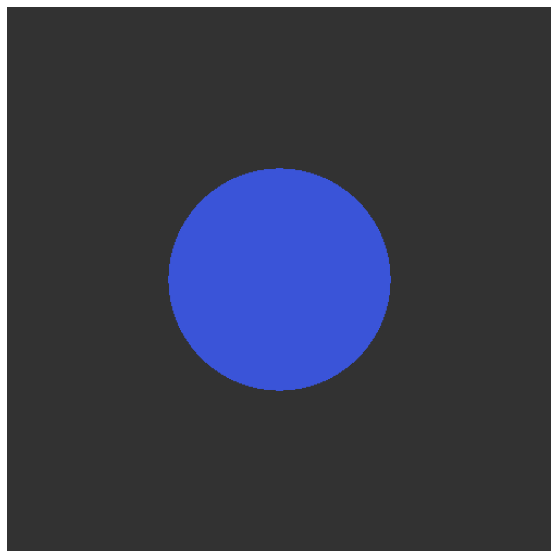

In [9]:
def coloration(depart, u) :
    if intersection(depart, u, centre, rayon) < inf :
        couleur = couleur_sphere
    else :
        couleur = vecteur(50,50,50)
    return couleur

for x in range(longueur):
        for y in range(hauteur) :
            u = unitaire(direction(x, y))
            couleur = coloration(Origine, u)
            image[y,x] = couleur.rgb()
            
plt.rcParams["figure.figsize"] = (10,10)    
plt.axis('off')
plt.imshow(image)


La commande **couleur.rgb()** permet de convertir le vecteur couleur au format nécessaire. Elle est définie dans vecteur.py et l'explication de son fonctionnement est ici peu pertinent. On obtient alors l'image ci-dessus, pour l'instant peu réaliste mais qui constitue tout de même notre tout premier pas en ce sens.


La sphère est ainsi retranscrite sur notre image par un cercle bleu qu'il va nous falloir nuancer en fonction de la position de la source de lumière, ce qui sera l'objet de la partie suivante.

### II.2) Que la lumière soit

Partons ici d'une remarque simple : un point situé sur une surface sera d'autant plus « éclairé » que la direction du vecteur le reliant à la source lumineuse est proche de celle de la normale. 

Le fait que la luminosité soit plus élevée aux alentours de midi en est un exemple connu et concret, en effet le soleil étant notre source de lumière principale cela signifie tout simplement qu'il s'agit du moment de la journée où ses rayons nous parviennent perpendiculairement.


Il devient alors nécessaire d'introduire les notations suivantes: 

- $M$: point en lequel on cherche à déterminer la couleur suivant la position d'une source de lumière $L$.
- $\vec{n}$: vecteur normal unitaire (dirigé côté source) en $M$. 
-  $\vec{\ell}=\dfrac{\overrightarrow{ML}}{\parallel\overrightarrow{ML}\parallel}$: vecteur unitaire de $M$ vers $L$.
-  $\theta=(\vec{n},\vec{\ell})$: angle entre les deux vecteurs, plus il est grand et moins ils sont « superposés ». 

<center>
<img src= "./Illustrations/source_lumiere.png" , width= "800" /></center>

D'après la remarque précédente, déterminer la coloration reviendrait à déterminer l'angle $\theta$. Il s'agit d'un problème qu'il est tout à fait possible de résoudre, cela dit il existe une manière moins fastidieuse de procéder. En effet, considérons le produit scalaire des vecteurs $\vec{n}$ et $\vec{\ell}$:

$$\vec{n}\cdot\vec{\ell}=\parallel\vec{n}\parallel\times\parallel\vec{\ell}\parallel\times\cos(\vec{n},\vec{\ell})=\cos(\theta)$$

$\vec{n}\cdot\vec{\ell}$ dépend donc ici uniquement de $\theta$, de sorte que plus la direction et le sens de $\vec{\ell}$ est proche de $\vec{n}$ et plus $\vec{n}\cdot\vec{\ell}$ est proche de 1 et réciproquement. 

Inversement plus $\theta$ s'approche d'un angle droit et plus 
$\vec{n}\cdot\vec{\ell}$ est proche de 0, ce que l'on peut par ailleurs visualiser plus facilement en deux dimensions avec le schéma suivant:

<center>
<img src= "./Illustrations/luminosite_produit_scalaire.png" style = 'width: 1200px' /></center>

Comme on peut le voir, $\vec{n}\cdot\vec{\ell}$ varie entre 0 et 1, c'est donc le candidat idéal pour faire office de « coefficient chromatique » en définissant: $$couleur_{finale} = (\vec{n}\cdot\vec{\ell}) \times couleur_{objet}$$.
Ainsi lorsque $\vec{\ell}=\vec{n}$, on retranscrit la totalité de la couleur de l'objet mais plus l'angle entre les deux vecteurs est grand et plus la proportion retranscrite est faible, ce résultat est parfois connu sous le nom de loi en cosinus de Lambert.
Ci-après un aperçu permettant de visualiser ce principe en dimension trois sur une surface plane:
<center>
<img src= "./Illustrations/luminosite_3d.png" style = 'width: 1200px' /></center>


L'objectif se précise mais le problème n'est pas encore tout à fait résolu: il est clair à présent qu'il nous faut pouvoir calculer $\vec{n}\cdot\vec{\ell}$ sans passer par $\theta$, ce qui implique de connaître les coordonnées des deux vecteurs unitaires dans l'espace. 
C'est cependant chose aisée puisque $\vec{\ell}=\dfrac{\overrightarrow{ML}}{\parallel\overrightarrow{ML}\parallel}$ et dans le cas de la sphère $\vec{n}=\dfrac{\overrightarrow{\Omega M}}{\parallel\overrightarrow{\Omega M}\parallel}$, de plus les coordonnées des points $\Omega$ et $L$ sont connues puisque c'est nous qui choisissons où les placer. 

Par ailleurs nous obtenons les coordonnées de $M$ dans le cas de la sphère grâce au raisonnement présenté en **II.2** et à la fonction **intersection**. 

Remarquons également que $\vec{n}\cdot\vec{\ell}$ reste positif tant que $\vec{n}$ est orienté "côte source", dans le cas contraire nous pouvons considérer que le point n'est pas éclairé, on utilisera donc plutôt **max** $(\vec{n}\cdot\vec{\ell},0)$ dans le programme pour s'épargner des valeurs négatives pour les couleurs.

Il ne reste alors plus qu'à placer la source de lumière et à modifier la fonction **coloration** suivant ce qui a été dit précédemment, ce qui permet de produire l'image suivante déjà beaucoup plus convaincante :

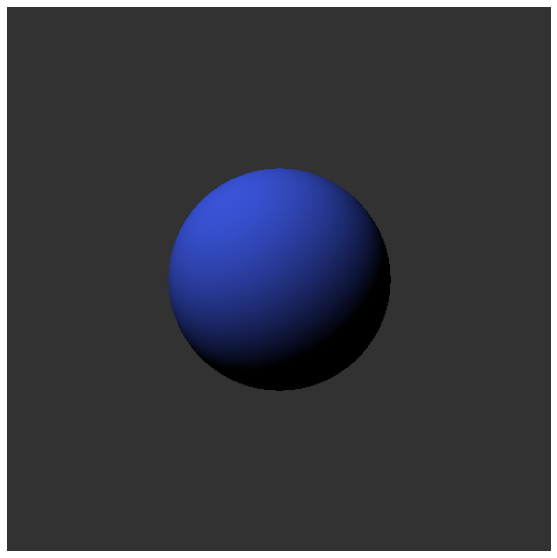

In [10]:
L =  vecteur(-20, -30, -20) # position de la source de lumiere

def coloration(depart, u) :
    t = intersection(depart, u, centre, rayon)
    if t < inf :
        OM = t * u
        ML = L - OM
        l = unitaire(ML)
        n = unitaire(OM - centre)
        couleur = couleur_sphere * max(scalaire(n, l),0)
    else :
        couleur = vecteur(50,50,50)
    return couleur

for x in range(longueur):
    for y in range(hauteur) :
        u = unitaire(direction(x, y))
        couleur = coloration(Origine, u)
        image[y,x] = couleur.rgb()
        
plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.imshow(image)

### III.3) Et la lumière fut


<center><img src= "./Illustrations/fig.jpg" , width = "500" /></center>

Comme on peut l'observer sur cette image certaines zones d'un objet présentent parfois un aspect brillant du fait que la lumière qui s'y reflète depuis la source atteint directement l'œil.

Afin de retranscrire cet effet il est nécessaire d'ajouter à la couleur une valeur supplémentaire appelée **composante spéculaire** que nous définirons selon le modèle d'ombrage de Phong explicité ci-après.

L'idée est ici, de manière analogue à la partie précédente, de mesurer l'écart angulaire entre le rayon lumineux issu de l'utilisateur réfléchi sur la sphère et le vecteur $\vec{\ell}$. Plus les deux sont proches et plus la lumière de la source a tendance a être redirigée vers l'observateur.

Il nous faut pour cela déterminer:
- $\vec{u}=\dfrac{\overrightarrow{OM}}{\parallel\overrightarrow{OM}\parallel}$ vecteur unitaire issu de l'origine vers $M$ où $M$ est le point de l'objet considéré.
- $\vec{r}$: vecteur unitaire de direction celle que suivrait la lumière si la surface était parfaitement réfléchissante. Ainsi l'angle formé avec la normale par le vecteur représentant le rayon incident est le même que celui formé entre la normale et le rayon réfléchi.
- L'angle $\beta=(\vec{r},\vec{n})=(\vec{n},-\vec{u})$ mentionné au point précédent.


<center>
<img src= "./Illustrations/reflexion_speculaire.png" , width = "800", height="750" /></center>

En reprenant les notations précédentes et le raisonnement présenté en **II.2**, on obtient:
$$composante~{speculaire} = couleur_{source} \times (\vec{r}\cdot \vec{\ell})$$

Le modèle de Phong incorpore de plus un paramètre $\alpha$ dépendant de l'objet considéré, plus sa valeur est grande et moins la zone brillante sera étendue:
$$composante~{speculaire} = couleur_{source} \times (\vec{r}\cdot \vec{\ell})^\alpha$$

Pour mieux comprendre le rôle de $\alpha$ il est intéressant d'examiner les courbes de représentatives des fonctions puissances sur l'intervalle $\left[0;1\right]$ représentées ci-après.


<center>
<img src= "./Illustrations/puissances.png" , width = "500" /></center>


En effet, nous pouvons ainsi constater que plus la puissance est grande et plus les valeurs des images des antécédents proches de 0 sont négligeables. Ce qui signifie dans le cas de notre modèle que plus la valeur de $\alpha$ choisie pour l'objet représenté est grande est plus la zone blanche autour du point reflétant directement le rayon jusqu'à l'observateur sera restreinte.
<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <img src="./Illustrations/alpha10.png" width="300"/>
         $\alpha = 10$
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="./Illustrations/alpha30.png" width="300"/>
         $\alpha = 30$
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="./Illustrations/alpha100.png" width="300"/>
         $\alpha = 100$
     </div>
</div>

<div class="alert alert-danger">
   <a href="#" class="alert-link">Proposition (preuve dans le pdf) :</a>  
$$\vec{r}=\vec{u}-2(\vec{u}\cdot\vec{n})\vec{n}$$ </div>

Après avoir rajouté les variable alpha et couleur lumiere, définissons alors la fonction **speculaire** qui calcule, à l'aide de la formule précédente, la composante spéculaire.

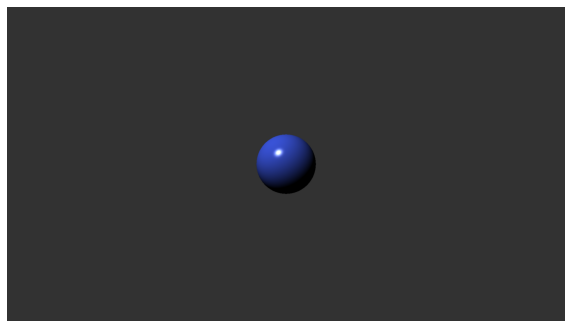

In [11]:
# caracteristiques de l image
longueur = 1920
hauteur = 1080
D = 500

image = zeros((hauteur, longueur, 3), dtype = uint8)

# caracteristiques de la sphere representee
rayon = 2
centre = vecteur(0, 0, 10)
couleur_sphere = vecteur(58, 84, 216)
alpha = 50

# source
L = vecteur(-20, -30, -20)
couleur_lumiere = vecteur(255,255,255) # lumiere blanche

def speculaire(u,n,l, alpha):
    if scalaire(l,n) > 0 :
        r = unitaire(u - 2 * scalaire(n, u) * n)
        speculaire = couleur_lumiere * max(scalaire(l, r),0)**alpha
    else :
        speculaire = vecteur(0,0,0)
    return speculaire

def coloration(depart, u) :
    t = intersection(depart, u, centre, rayon) 
    if t < inf :
        OM = t * u
        ML = L - OM
        l = unitaire(ML)
        n = unitaire(OM - centre)
        couleur = couleur_sphere * max(scalaire(n, l),0)
        spec = speculaire(u,n,l, alpha)
        couleur += spec
    else :
        couleur = vecteur(50,50,50)
    return couleur

for x in range(longueur):
    for y in range(hauteur) :
        u = unitaire(direction(x, y))
        couleur = coloration(Origine, u)
        image[y, x] = couleur.rgb()

plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.imshow(image)

## IV) Et de deux!

### IV.1) Ombres

Nous allons à présent chercher à représenter plusieurs sphères, ce qui amène des contraintes supplémentaires, à savoir :
- Pour un pixel donné, identifier la première sphère atteinte par le rayon correspondant, qui se situera donc au premier plan et déterminera la couleur attribuée au pixel.
- L'endroit atteint est-il éclairé par la source lumineuse? Autrement dit y-a-t il un obstacle entre le point atteint sur la sphère et la source lumineuse?

Avant de répondre à ces questions, définissons ensemble l'ensemble des objets présents que nous appellerons la scène. Dans notre cas elle est constituée uniquement de sphères définies par la syntaxe suivante : $\text{sphere(centre, rayon, couleur, alpha)}$ où la couleur et le centre sont des vecteurs et le rayon et alpha sont des scalaires.

In [12]:
from sphere import*

# le sol est ici une sphere de grand rayon
sol = sphere(vecteur(0, 10**7 + 5 , 0 ), 10**7, vecteur(154, 132, 120), 10**8)   

sphere_1 = sphere(vecteur(1, 4.5, 15 ), 0.5, vecteur(52, 84, 216), 20)   # boule bleue
sphere_2 = sphere(vecteur(4, 4, 20 ), 1, vecteur(237, 33, 58), 15 )   # boule rouge
sphere_3 = sphere(vecteur(-4, 3, 25 ), 2, vecteur(60, 165, 92), 10 )     # boule verte

scene = [sol, sphere_1, sphere_2, sphere_3]

luminosite_ambiante = vecteur(20,20,20) # luminosite ambiante

Une fois la scène définie, il nous faut remédier aux deux points mentionnés précédemment :
- Soit $P$ un pixel, la fonction intersection nous permet de savoir si la droite $(OP)$ intersecte chacun des objets de la scène, il y en a donc potentiellement plusieurs. Dans notre représentation celui qui nous intéresse est celui qui se situe au premier plan par rapport aux autres, autrement dit celui réalisant la distance minimale par rapport à l'origine.
- Une fois cela fait, soit $M$ le point de la sphère ainsi atteinte, il nous faut à présent déterminer si la zone où se situe $M$ est dans l'ombre d'un autre objet de la scène ou pas. Pour cela nous allons untiliser à nouveau la fonction $\text{intersection}$ en prenant $M$ pour point de départ et $\overrightarrow{ML}$ pour direction, où $L$ est la source lumineuse, si l'une des distances ainsi obtenue est inférieure à $ML$ on peut en conclure que le point atteint est dans l'ombre d'un autre objet de la scène.
- Ainsi, si pour poure toute sphère différente de celle atteinte : $\text{intersection}(M, \overrightarrow{\ell}, \text{centre}, \text{rayon}) > ML$, alors on effectue la coloration précédente.
    Sinon on lui attribue une couleur qui doit correspondre à une ombre, pour cela on peut procéder de différente manière, ici nous utiliserons la couleur obtenue par la coloration multipliée par un coefficient de $0,35$ pour l'assombrir. 

Modifions ainsi la fonction $\text{coloration}$ :

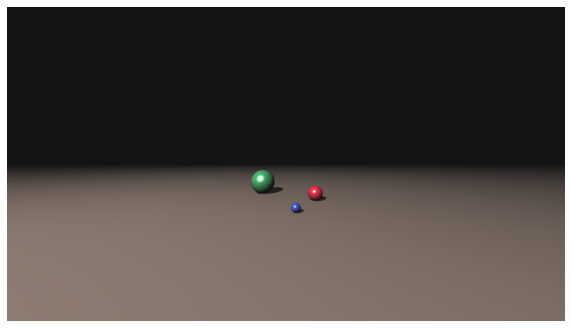

In [13]:
def coloration(depart, u) :
    intersections = [intersection(depart, u, objet.centre, objet.rayon) for objet in scene]
    d = min(intersections) 
    couleur = luminosite_ambiante
    if d < inf :
        # rang dans la liste des distances realisant le min
        k = intersections.index(d)
        # objet de la scene correspondant a la distance minimale 
        objet = scene[k]
        M = d * u
        ML = L - M
        l = unitaire(ML)
        n = unitaire(M - objet.centre)
        couleur = couleur +  objet.couleur * max(scalaire(n, l),0)  
        # on verifie s'il y a un objet cachant la source lumineuse
        if min([intersection(M, l, obj.centre, obj.rayon) for obj in scene if obj != objet]) < norme(ML) :
            couleur *=.35
        else :
            spec = speculaire(u, n, l, objet.alpha)
            couleur += spec 
    return couleur

for x in range(longueur):
    for y in range(hauteur) :
        u = unitaire(direction(x, y))
        couleur = coloration(Origine, u)
        image[y, x] = couleur.rgb()

plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.imshow(image)

### IV.2) Reflets

Pour faire apparaître un reflet sur un objet de la scène, il suffit de :

- Déterminer le point $M$ de l'objet atteint.
- Utiliser à nouveau la fonction *intersection* en prenent cette fois $M$ comme point de départ et comme direction celle du vecteur $\vec{r}$.
- Récupérer la couleur du nouvel objet ainsi atteint.
- Calculer la moyenne des couleurs, pondérée par un coefficient de réflexion choisi (qui dépendrait physiquement de la matière de la surface considérée et de sa rugosité).

Pour cela nous allons à nouveau modifier la fonction $\text{coloration}$ : 

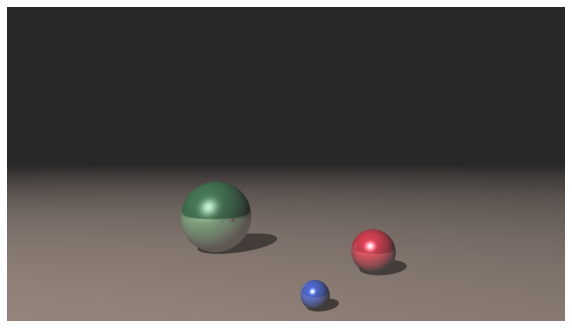

In [45]:
# le sol est ici une sphere de grand rayon
sol = sphere(vecteur(0, 10**8 + 5 , 0 ), 10**8, vecteur(154, 132, 120), 10**8, 0)

sphere_1 = sphere(vecteur(1, 4.5, 15 ), 0.5, vecteur(52, 84, 216), 20, .2)    # boule bleue
sphere_2 = sphere(vecteur(4, 4, 20 ), 1, vecteur(237, 33, 58), 15,  .25)    # boule rouge
sphere_3 = sphere(vecteur(-4, 3, 25 ), 2, vecteur(60, 165, 92),10, 0.5)     # boule verte
D=2000
scene = [sol, sphere_1, sphere_2, sphere_3]

# source
L = vecteur(-20, -30, -20)
couleur_lumiere = vecteur(255,255,255) # lumiere blanche
luminosite_ambiante = vecteur(40,40,40) # luminosite ambiante

def coloration(depart, u, objets) :
    intersections = [intersection(depart, u, objet.centre, objet.rayon) for objet in objets]
    d = min(intersections)
    couleur = luminosite_ambiante # on prend la luminosite ambiante comme "couleur minimale" que l'on augmentera au fur et a mesure
    if d < inf :
        k = intersections.index(d)
        objet = objets[k]
        objets.remove(objet) # on retire l'objet atteint
        M = d * u
        n = unitaire(M - objet.centre)
        ML = L - M
        l = unitaire(ML)
        # on verifie s'il y a un objet cachant la source lumineuse
        if min([intersection(M, l, obj.centre, obj.rayon) for obj in objets]) < norme(ML) :
            couleur = (couleur + objet.couleur)*.35 # dans ce cas on colorie le pixel avec 35% de la couleur
        else :
            spec = speculaire(u, n, l, objet.alpha)
            couleur += objet.couleur* max(scalaire(n, l),0) + spec
            r = u - 2*scalaire(u,n)*n #on determine le rayon reflechi en M
            reflet = coloration(M, r, objets) 
            # on suit le rayon reflechi jusqu'a l'objet suivant et on recupere 
            # sa couleur ponderee par le coefficient de reflexion du premier objet atteint
            couleur = (1 - objet.reflexion)* couleur + objet.reflexion* reflet
            # on obtient le reflet en calculant la moyenne ponderee entre la couleur de l'objet et celle obtenue par reflexion
    return couleur

for x in range(longueur):
    for y in range(hauteur) :
        list_obj = scene.copy() # on realise une copie de la liste contenant les objets de la scene
        u = unitaire(direction(x, y))
        couleur = coloration(Origine, u, list_obj)
        image[y,x] = couleur.rgb()

#plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.imshow(image)
plt.imsave('Boules_1920.png', image)

## V) Maillages triangulaires
### V.1) Représentation d'un plan

Pour représenter un plan $\mathscr{P}$, on procède de manière similaire excepté pour la recherche de l'intersection entre $\mathscr{P}$ et $(OP)$. 

Pour définir ce plan, nous utiliserons trois points de l'espace non alignés $A,B$ et $C$, à partir desquels nous pourrons déduire un vecteur normal $\vec{n}$ à l'aide du produit vectoriel $\overrightarrow{AB}\wedge \overrightarrow{AC}$.

$\bullet~ \vec{u}\cdot\vec{n}=0\Leftrightarrow \mathscr{P}\cap(OP) = \varnothing$ ou $\mathscr{P}\cap(OP) =(OP)$. Dans ce cas on ne représente rien, la fonction *intersection* renverra $+\infty$.

$\bullet $ Dans le cas contraire : $\vec{u}\cdot\vec{n}\neq 0$, auquel cas notons $M$ l'intersection entre $\mathscr{P}$ et $(OP)$,  on cherche alors $t$ tel que : $\overrightarrow{OM}=t\vec{u}=\overrightarrow{OA}+\overrightarrow{AM}$. 

Puisque $\overrightarrow{AM}$ est orthogonal à $\vec{n}$, on a : $t\vec{u}\cdot\vec{n}=\overrightarrow{OA}\cdot\vec{n}$. D'où $t=\dfrac{\overrightarrow{OA}\cdot\vec{n}}{\vec{u}\cdot\vec{n}}$



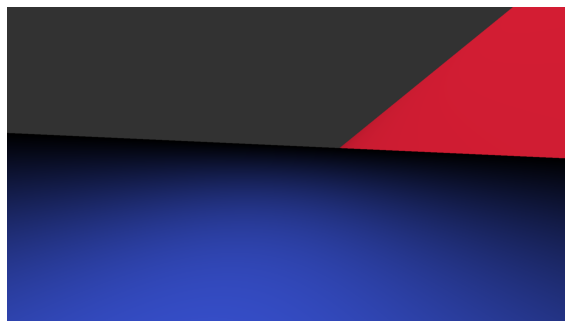

In [58]:
O = vecteur(0,0,0)
A = vecteur(1, 4.5, 15 )
B = vecteur(4, 4, 20 )
C = vecteur(-4, 3, 25 )

Face = [A,B,C]

def normal(plan) :
    A, B, C = plan
    u = B - A
    v = C - A
    x = u.y*v.z - u.z*v.y
    y = u.z*v.x - u.x*v.z
    z = u.x*v.y - u.y*v.x
    return vecteur(x, y, z)
    
def interplan(depart, u, plan) :
    n = normal(plan)
    OA = plan[0] - depart
    if scalaire(u, n) == 0 :
        return inf
    else :
        t = scalaire(OA, n)/scalaire(u,n)
        if t < 0 :
            return inf
        else :
            return t

def coloration(depart, u) :
    t = interplan(depart, u, Face)
    if t  < inf :
        OM = t* u
        ML = L - OM
        l = unitaire(ML)
        n = unitaire(normal(Face))
        couleur = vecteur(58, 84, 216) * max(scalaire(n, l),0) 
        image[y,x] = couleur.rgb()

for x in range(longueur):
        for y in range(hauteur) :
            u = unitaire(direction(x, y))
            couleur = coloration(O, u)
            
plt.rcParams["figure.figsize"] = (10,10)    
plt.axis('off')
plt.imshow(image)

# V.2) Représentation d'une face triangulaire

Afin de représenter la face triangulaire correspondant au triangle $ABC$, nous utiliserons les coordonnées barycentriques $(\alpha,\beta,\gamma)$ tels que : $\alpha\overrightarrow{AM}+\beta\overrightarrow{BM}+\gamma\overrightarrow{CM}=\vec{0}$ avec $\alpha+\beta+\gamma =1$

Il suffira donc de vérifier si $\alpha,\beta$ et $\gamma$ sont tous positifs pour savoir si $M$ se situe à l'intérieur du triangle $ABC$.

$\alpha\overrightarrow{AM}+\beta\overrightarrow{BM}+\gamma\overrightarrow{CM}=\vec{0}\Leftrightarrow \alpha\overrightarrow{AM}+\beta(\overrightarrow{BA} + \overrightarrow{AM})+\gamma(\overrightarrow{CA} + \overrightarrow{AM}) =\vec{0}\Leftrightarrow  (\alpha+\beta+\gamma)\overrightarrow{AM}= \beta\overrightarrow{AB}+\gamma\overrightarrow{AC} \Leftrightarrow \overrightarrow{AM}=\beta\overrightarrow{AB}+\gamma\overrightarrow{AC}$

Pour faciliter la recherche de $\beta$ et $\gamma$, construisons un repère orthonormé $(A,\vec{v},\vec{w})$ en orthonormalisant le repère $(A,\overrightarrow{AB},\overrightarrow{AC})$ : 

<center>
<img src= "./Illustrations/Orthonormalisation.png" , width= "800" /></center>

\begin{eqnarray}
\vec{v}=\dfrac{\overrightarrow{AB}}{\left|\left|\overrightarrow{AB}\right|\right|}\qquad \text{et} \qquad \vec{w}=\dfrac{\overrightarrow{AC}-(\overrightarrow{AB}\cdot\overrightarrow{AC})\vec{v}}{\left|\left| \overrightarrow{AC}-(\overrightarrow{AB}\cdot\overrightarrow{AC})\vec{v}\right|\right|}. \qquad (1)
\end{eqnarray} 
Ainsi la recherche de $\beta$ et $\gamma$ se ramène à la recherche de $a$ et $b$ tels que : $\overrightarrow{AM}=\beta\overrightarrow{AB}+\gamma\overrightarrow{AC}=a\vec{v}+b\vec{w}$

$\vec{v}$ (et donc $\overrightarrow{AB}$) et $\vec{w}$ étant orthogonaux on en déduit par produit scalaire :

$(2)\begin{cases}
\beta\overrightarrow{AB}\cdot\vec{w}+\gamma\overrightarrow{AC}\cdot\vec{w}=a\vec{v}\cdot\vec{w}+b\vec{w}\cdot\vec{w} \Leftrightarrow \gamma\overrightarrow{AC}\cdot\vec{w}=b\Leftrightarrow \gamma = \dfrac{b}{\overrightarrow{AC}\cdot\vec{w}}\qquad  \qquad (\overrightarrow{AC}\cdot\vec{w}\neq 0 ~ \text{puisque A,B et C sont non alignés.)}\\
\beta\overrightarrow{AB}\cdot\vec{v}+\gamma\overrightarrow{AC}\cdot\vec{v}=a\vec{v}\cdot\vec{v}+b\vec{w}\cdot\vec{v} \Leftrightarrow \beta = \dfrac{a-\gamma (\overrightarrow{AC}\cdot\vec{v})}{\overrightarrow{AB}\cdot\vec{v}} \qquad \end{cases}$

Reste à déterminer $a$ et $b$ à partir de la relation : $\qquad t\vec{u}=\overrightarrow{OA}+\overrightarrow{AM}=\overrightarrow{OA}+a\vec{v}+b\vec{w} \iff a\vec{v}+b\vec{w}=-\overrightarrow{OA}+t\vec{u}$

Par produit scalaire avec $\vec{v}$ et $\vec{w}$ on en déduit : $\qquad a=\left(-\overrightarrow{OA}+t\vec{u}\right)\cdot\vec{v}\qquad$
 et $\qquad b=\left(-\overrightarrow{OA}+t\vec{u}\right)\cdot\vec{w}\qquad (3)$
 

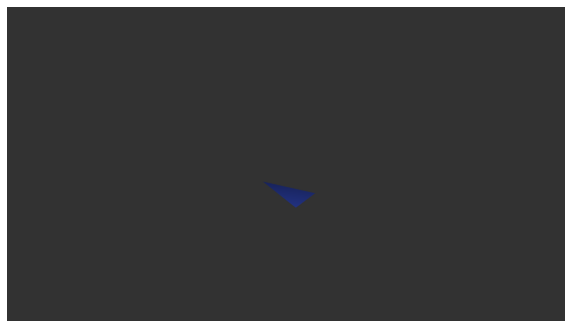

In [59]:
def triangle(depart, u, Face, t) :
    A, B, C = Face
    OA = A - depart
    AB = B - A
    AC = C - A
    # Formules (1) :
    v = unitaire(AB) 
    w = unitaire(AC - scalaire(AC,v)*v)
    # Formules (3) :
    a = scalaire((t*u - OA), v) 
    b = scalaire((t*u - OA), w) 
    # Formules (2) :
    gamma = b/scalaire(AC, w) 
    beta = (a - gamma*scalaire(AC, v))/scalaire(AB, v) # (2)
    return min(beta, gamma, 1 - beta - gamma) >= 0 
    # revient a determiner si tous les coefficients barycentriques sont positifs et donc si M est dans le triangle ABC

def coloration(depart, u) :
    t = interplan(depart, u, Face)
    if t < inf and triangle(depart, u, Face, t) == True : # on effectue la coloration uniquement si M est dans le triangle
        OM = t* u
        ML = L - OM
        l = unitaire(ML)
        n = unitaire(normal(Face))
        couleur = vecteur(58, 84, 216) * max(scalaire(n, l),0)
    else :
        couleur = vecteur(50,50,50)
    return couleur

A = vecteur(1, 4.5, 15 )
B = vecteur(4, 4, 20 )
C = vecteur(-4, 3, 25 )
Face = [A,B,C]

image = zeros((hauteur, longueur, 3), dtype = uint8)
for x in range(longueur):
        for y in range(hauteur) :
            u = unitaire(direction(x, y))
            couleur = coloration(O, u)
            image[y,x] = couleur.rgb()
            
plt.rcParams["figure.figsize"] = (10,10)    
plt.axis('off')
plt.imshow(image)


### V.3) Polyèdres

Afin de reprèsenter un polyèdre quelconque, il suffit de le définir comme étant une liste de faces triangulaires que l'on pourra représenter à parti du raisonnement précédent.

Il nous faut alors déterminer, parmi les faces triangulaires laquelle est atteinte en premier par la droite $(OP)$. Pour cela, il faut :

$\bullet$ Déterminer les intersections possibles entre la droite $(OP)$ et tous les plans associés à chaque face.

$\bullet$ Pour chacune de ces intersections, vérifier si le potentiel point d'intersection est à l'intérieur du triangle.

$\bullet$ Si aucun des points d'intersections n'appartient à l'un des triangles prédéfinis, on colorie le pixel en gris.

$\bullet$ Sinon on retient uniquement le point d'intersection le plus proche de l'observateur (la valeur de $t$ la plus petite).

In [68]:
Faces = [[A,B,C], [A, B, vecteur(1, 2, 15 )],[C, A, vecteur(1, 2, 15 )]]

# liste de couleurs
Couleurs = [vecteur(237, 33, 58), vecteur(60, 165, 92),vecteur(52, 84, 216), vecteur(255, 255, 128), vecteur(182, 151, 216),
           vecteur(64,128,128), vecteur(255,128,64), vecteur(255,128,192)]

def coloration(depart, u) :
    inter = [interplan(depart, u, face) for face in Faces]
    triangles = [triangle(depart,u, Faces[k], inter[k]) for k in range(len(Faces))]
    if all(triangle == False for triangle in triangles) :#autre idee prendre min(inter) + boucle while
        couleur = vecteur(50,50,50)
    else :
        t = min([inter[k] for k in range(len(inter)) if triangles[k]]) # plus petite distance par rapport a l'observateur.
        k = inter.index(t) # rang de la face la plus proche de l'observateur dans cette direction.
        face = Faces[k] # on retient la face la plus proche de l'observateur dans cette direction.
        OM = t* u
        ML = L - OM
        l = unitaire(ML)
        n = unitaire(normal(face))
        couleur = Couleurs[k] * abs(scalaire(n, l))
        # on prend la valeur absolue afin d'eviter le cas ou le vecteur normal est du "mauvais sens"
    return couleur


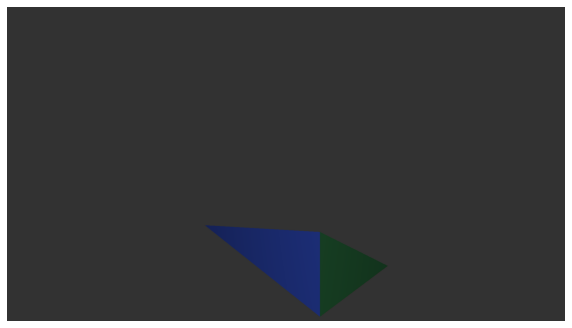

In [70]:

D = 1750
L = vecteur(-2.5, -5, -10)
image = zeros((hauteur, longueur, 3), dtype = uint8)
for x in range(longueur):
        for y in range(hauteur) :
            u = unitaire(direction(x, y))
            couleur = coloration(O, u)
            image[y,x] = couleur.rgb()
            
#plt.rcParams["figure.figsize"] = (10,10)    
plt.axis('off')
plt.imshow(image)
plt.imsave('Tetraedre_1920.png', image)

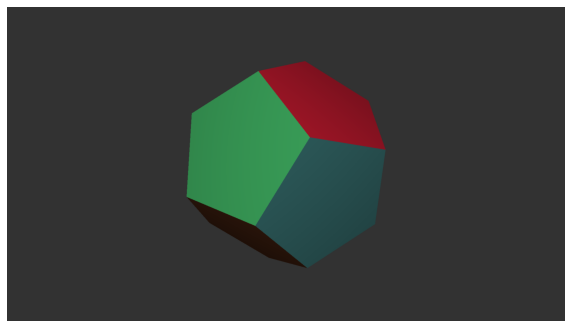

In [53]:
from random import randint
from math import pi

# faces du dodecaedre regulier definies a partir des coordonnees des sommets
phi = (1 + 5**.5)/2
Face1 = [vecteur(1,-1,-1), 
         vecteur(0,-phi,-1/phi), 
         vecteur(0,-phi,1/phi), 
         vecteur(1,-1,1), 
         vecteur(phi, -1/phi, 0)]
Face2 = [vecteur(1,-1,-1), 
         vecteur(0,-phi,-1/phi), 
         vecteur(-1,-1,-1), 
         vecteur(-1/phi, 0, -phi), 
         vecteur(1/phi, 0, -phi)]
Face3 = [vecteur(0,-phi,-1/phi), 
         vecteur(0,-phi,1/phi), 
         vecteur(-1,-1,1), 
         vecteur(-phi, -1/phi, 0),
        vecteur(-1,-1,-1)]
Face4 = [vecteur(0,-phi,1/phi), 
         vecteur(1,-1,1), 
         vecteur(1/phi, 0, phi), 
         vecteur(-1/phi, 0, phi),
         vecteur(-1,-1,1)]
Face5 = [vecteur(1,-1,1), 
         vecteur(phi, -1/phi, 0), 
         vecteur(phi, 1/phi, 0), 
         vecteur(1,1,1), 
         vecteur(1/phi, 0, phi)]
Face6 = [vecteur(phi, -1/phi, 0), 
         vecteur(phi, 1/phi, 0), 
         vecteur(1,1,-1), 
         vecteur(1/phi, 0, -phi), 
         vecteur(1,-1,-1)]
Face7 = [vecteur(-1/phi, 0, -phi), 
         vecteur(1/phi, 0, -phi), 
         vecteur(1,1,-1),  
         vecteur(0,phi,-1/phi), 
         vecteur(-1,1,-1)]
Face8 = [vecteur(-1/phi, 0, -phi), 
         vecteur(-1,1,-1), 
         vecteur(-phi, 1/phi, 0), 
         vecteur(-phi, -1/phi, 0), 
         vecteur(-1,-1,-1)]
Face9 = [vecteur(-phi, 1/phi, 0), 
         vecteur(-phi, -1/phi, 0), 
         vecteur(-1,-1,1), 
         vecteur(-1/phi, 0, phi), 
         vecteur(-1,1,1)]
Face10 = [vecteur(-1/phi, 0, phi), 
          vecteur(-1,1,1), 
          vecteur(0,phi,1/phi), 
          vecteur(1,1,1), 
          vecteur(1/phi, 0, phi)]
Face11 = [vecteur(0,phi,1/phi), 
          vecteur(1,1,1),  
          vecteur(phi, 1/phi, 0), 
          vecteur(1, 1, -1), 
          vecteur(0,phi, -1/phi)]
Face12 = [vecteur(0,phi, 1/phi), 
          vecteur(0,phi, -1/phi), 
          vecteur(-1,1,-1), 
          vecteur(-phi, 1/phi, 0),
          vecteur(-1,1,1)]

faces = [Face1, Face2, Face3, Face4, Face5, Face6, Face7, Face8, Face9, Face10, Face11, Face12]
faces = [ [4*face[k].rotx(pi/6).roty(pi/6).rotz(pi/12) + vecteur(0,0,20) for k in range(5)] for face in faces]
Faces = []
# triangulation des faces pentagonales
for j in range(12) :
    face = faces[j]
    l = [[face[0], face[i], face[i + 1]] for i in range(1, 4)]
    Faces += l

longueur = 1920
hauteur = 1080
D = 1000
image = zeros((hauteur, longueur, 3), dtype = uint8)
L = vecteur(-2.5, -5, -10)

for x in range(longueur):
        for y in range(hauteur) :
            u = unitaire(direction(x, y))
            couleur = coloration(O, u)
            image[y,x] = couleur.rgb()
            
#plt.rcParams["figure.figsize"] = (10,10)    
plt.axis('off')
plt.imshow(image)
plt.imsave('Dodecaedre_1920.png', image)

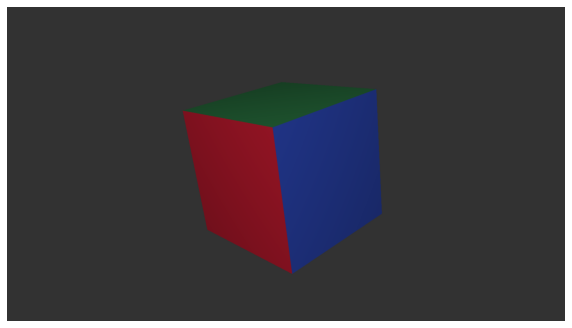

In [50]:
# sommets du cube 
D = 1500
H = vecteur(-1,-1,-1)
A = vecteur(1, -1, -1)
B = vecteur(1, 1, -1)
C = vecteur(-1, 1, -1)
D1 = vecteur(-1, 1, 1)
E = vecteur(-1, -1, 1)
F = vecteur(1, -1, 1)
G = vecteur(1, 1, 1)

triangles = [[H,A,B], [H,C,B], [H,A,F], [H,E,F], [A,B,G], [A,F,G], [B,C,D1], [B,D1,G], [C,H,E], [C,D1,E], [D1,E,F], [D1,G,F]] 
Faces = [ [3*face[k].rotx(pi/6).roty(pi/4).rotz(pi/12) + vecteur(0,0,20) for k in range(3)] for face in triangles]
def coloration(depart, u) :
    inter = [interplan(depart, u, face) for face in Faces]
    triangles = [triangle(depart,u, Faces[k], inter[k]) for k in range(len(Faces))]
    if all(triangle == False for triangle in triangles) :#autre idee prendre min(inter) + boucle while
        couleur = vecteur(50,50,50)
    else :
        t = min([inter[k] for k in range(len(inter)) if triangles[k]]) # plus petite distance par rapport a l'observateur.
        k = inter.index(t) # rang de la face la plus proche de l'observateur dans cette direction.
        face = Faces[k] # on retient la face la plus proche de l'observateur dans cette direction.
        OM = t* u
        ML = L - OM
        l = unitaire(ML)
        n = unitaire(normal(face))
        couleur = Couleurs[(k//2)%len(Couleurs)] * abs(scalaire(n, l))
        # on prend la valeur absolue afin d'eviter le cas ou le vecteur normal est du "mauvais sens"
    return couleur
for x in range(longueur):
        for y in range(hauteur) :
            u = unitaire(direction(x, y))
            couleur = coloration(O, u)
            image[y,x] = couleur.rgb()
            
#plt.rcParams["figure.figsize"] = (10,10)    
plt.axis('off')
plt.imshow(image)
plt.imsave('Cube_1920.png', image)